# Clean RS Data - Clouds, Shadows & Cloud Masks

You will learn how to deal with clouds in your RS data. There is no perfect solution of course. You will just learn 1 approach.

In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Prettier plotting with seaborn
sns.set_style("white")
sns.set(font_scale=1.5)

# Download data and set work dir
data = et.data.get_data("cold-springs-fire")os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

Next, you will load and plot LS data.

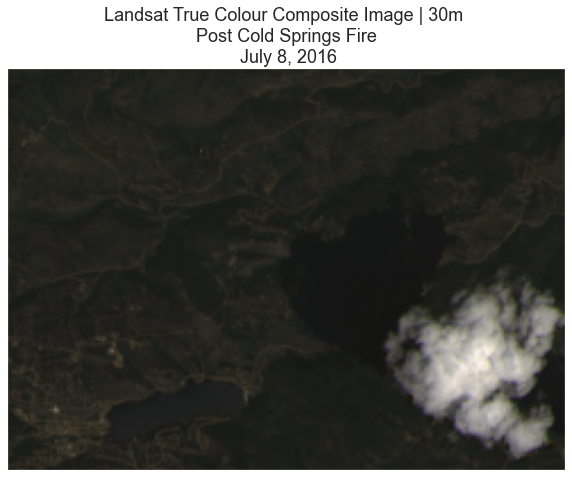

In [4]:
landsat_paths_pre_path = os.path.join("data", "cold-springs-fire", "landsat_collect", 
                                      "LC080340322016070701T1-SC20180214145604", "crop", 
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

# Stack the LS pre fire data
landsat_pre_st_path = os.path.join("data", "cold-springs-fire",
                                  "outputs", "landsat_pre_st.tif")

es.stack(landsat_paths_pre, landsat_pre_st_path)

# Read LS pre fire data
with rio.open(landsat_pre_st_path) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    landsat_extent = plotting_extent(landsat_pre_src)
    
    ep.plot_rgb(landsat_pre,
               rgb=[3, 2, 1],
               extent=landsat_extent,
               title="Landsat True Colour Composite Image | 30m \n Post Cold Springs Fire \n July 8, 2016")
    
    plt.show()

Notice in the data above there is a large cloud in your scene. This cloud will impact any quantitative analysis that you perform on the data. You can remove cloudy pixels using a mask. Masking "bad" pixels:

1. Allows you to remove them from any quantitative analysis that you may perform such as calculating NDVI.
2. Allows you to replace them (if you want) with better pixels from another scene. This replacement if often performed when performing timeseries analyiss of the data. The following lesson will teach you to replace pixels ina scene.

## Cloud masks

You can use the cloud mask layer to identify pixels that arelikely to be clouds or shadows. You can then set those pixel values to masked so they are not included in your quantitative analysis in Python.

When you say "mask", you are talking about a layer that "turns off" or sets to nan, the values of pixels in a raster that you don'T want to include in an analysis. It's very simiöar to setting data points that equal -9999 to nan in a timeseries dataset. You are just doing it with spatial raster data instead.

![raster_masks](raster_masks.jpg)

## Raster masks for RS data

Many RS datasets come with quality layers that you can use as a mask to remove "bad" pixels from your analysis. IN the case of Landsat, the mask layers identify pixels that are likely representative of cloud cover, shoadow and even water. When you download LS8 data from Earth Explorer, the data came with a processed cloud shadow/mask raster layer called landsat_file_name_pixel_qa.tif. Just replace the name of your LS scene with the text landsat_file_name above.

You will explore using this pixel quality assurance (QA) layer, next. TO begin, open the pixel_qa layer using rasterio and plot it with matplotlib.

In [6]:
landsat_pre_cl_path = os.path.join("data", "cold-springs-fire", "landsat_collect",
                                  "LC080340322016070701T1-SC20180214145604", "crop", 
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

# Open the pixel_qa layer for your landsat scene
with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_ext = plotting_extent(landsat_pre_cl)

First, plot the pixel_qa layer in matplotlib.

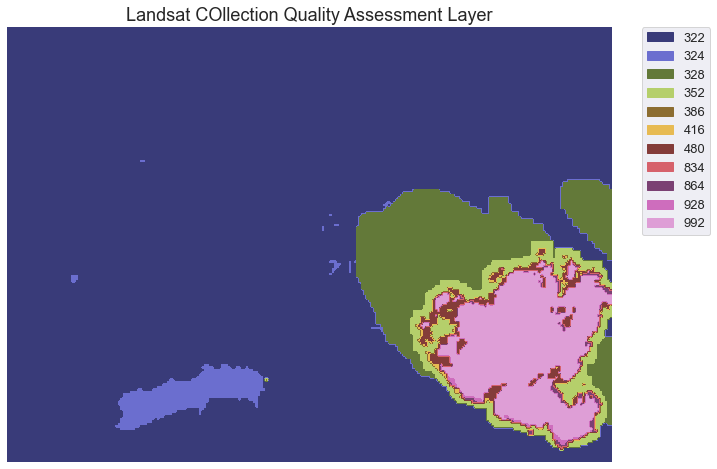

In [13]:
# This is optional code to plot the qa layer
# Create a colourmap with 11 colours
cmap = plt.cm.get_cmap("tab20b", 11)

# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals

# Normalise the colourmap
bounds = [((a + b)/2) for a, b in zip(bins[: -1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
              cmap=cmap,
              norm=norm)

ep.draw_legend(im,
              classes=vals,
              cmap=cmap, titles=vals)

ax.set_title("Landsat COllection Quality Assessment Layer")
ax.set_axis_off()

plt.show()

In the image above, you can see the cloud and the shadow that is obstructing our LS image. Unfortunately for you, this cloud covers a part of your analysis area in the Cold Sorings FIre Location. There are a few ways to handle this issue. We will look at 1: simply masking out or removing the cloud for your analysis, first.

To remove all pixels that are cloud and cloud shadow covered we need to first determine what each value in our qa raster represents. The table below is from the USGS landsat website. It describes what all of the values in the pixel_qa layer represent.

We are interested in
1. cloud shadow
2. cloud and
3. high confidence cloud

Note that your specific analysis may require a different set of masked pixels. For instance, your analysis may require you identify pixels that are low confidence clouds too. We are just using these classes for the purpose of this class.

To better understand the values above, create a better map of the data. To do that you will:
1. classify the data into x classes where x represents the total number of unique values in the pixel_qa raster.
2. plot the data using these classes.

We are reclassifying the data because matplotlib colormaps will assign colors to values along a continuous gradient. Reclassifying the data allows us to enforce 1 colour for each unique value in our data.

This next section shows you how to create a mask using the earthpy mask help function _create_mask to create a binary cloud mask layer. In this mask all pixels that you wish to remove from your analysis or mask will be set to 1. ALl other pixels which represent pixels you want to use in your analysis will be set to 0.

### NOTE:
This step can be done by changing the inputs into the main mask_pixels function. We include it here so you can see what is going on in the function. See lower down in the lesson for this call.

In [14]:
vals

[322, 324, 328, 352, 386, 416, 480, 834, 864, 928, 992]

In [15]:
# You can grab the cloud pixel values from earthpy
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
all_masked_values

[328,
 392,
 840,
 904,
 1350,
 352,
 368,
 416,
 432,
 480,
 864,
 880,
 928,
 944,
 992,
 480,
 992]

In [17]:
# This is using a helper function from earthpy to create the mask so we can plot it
cl_mask = em._create_mask(landsat_qa, all_masked_values)
np.unique(cl_mask)

array([0, 1], dtype=int16)

## What does the metadata tell you?

What do the values stored in those raster mean? You can refer to the metadata provided by USGS to learn more about how each layyer in your LS dataset are both stored and calculated.

When you download RS data, often (but not always), you will find layers that tell us more about the error and uncertainty in the data. Often whomever created the data will do some of the work for us to detect where clouds and shadows are - given they are common challenges that you need to work around when using RS data.

### Create mask layer

To create the mask, you do the following:
1. Make sure you use a raster layer for the mask that is the SAME EXTENT and the same pixel resolution as your landsat scene. In this case you have a mask laayer that is already the same spatial resolution and extent as your LS scene.
2. Set all of the values in that layer that are clouds and/or shadows to 1 (1 to represent mask = True)
3. Finally you use the masked_array function to apply the mask layer to the numpy array (or the LS scene that you are working with in Python). All pixel locations that were flagged as clouds or shadows in your mask to NA in your raster or in this case rasterstack.

## Mask a LS scene using earthpy

Below you mask your data in 1 single step. This function em.mask_pixels() creates the mask as you saw above and then masks your data.

In [19]:
# Call the earthpy mask function using your mask layer
landsat_pre_cl_free = em.mask_pixels(landsat_pre, cl_mask)

Alternatively, you can directly input your mask values and the pixel QA layer into the mask_pixels function. This is the easiest way to mask your data!

In [21]:
# Call the earthpy mask function using pixel QA layer
landsat_pre_cl_free = em.mask_pixels(landsat_pre, cl_mask)

Alternatively, you can directly input your mask values and the pixel QA layer into the mask_pixels function. This is the easiest way to mask your data!

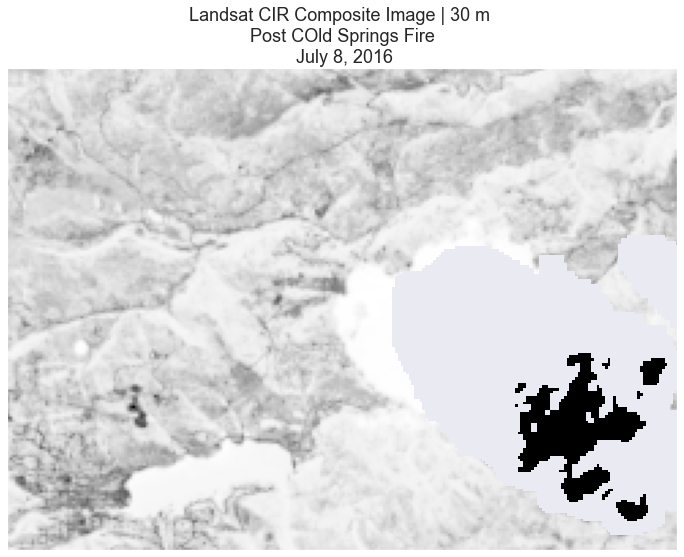

In [22]:
# Call the earthpy mask function using pixel QA layer
landsat_pre_cl_free = em.mask_pixels(
    landsat_pre, landsat_qa, vals=all_masked_values)

# Plot the data
ep.plot_bands(landsat_pre_cl_free[6],
             extent=landsat_extent,
             cmap="Greys",
             title="Landsat CIR Composite Image | 30 m \n Post COld Springs Fire \n July 8, 2016",
             cbar=False)

plt.show()

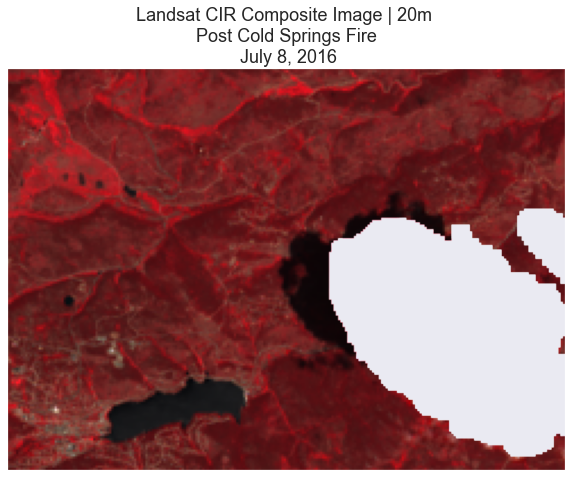

In [23]:
# Plot data
ep.plot_rgb(landsat_pre_cl_free,
           rgb=[4, 3, 2],
           extent=landsat_ext,
           title="Landsat CIR Composite Image | 20m \n Post Cold Springs Fire \n July 8, 2016")

plt.show()